In [1]:
import re,jieba
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models.word2vec import Word2Vec,LineSentence
from progressbar import progressbar
from tqdm import tqdm

C:\Users\eiahb\AppData\Local\conda\conda\envs\env_ml\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [34]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense ,LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [3]:
PADDING_LENGTH=150
ROOT="D:/work/school/machine learning/hw/hw4/"

# preprocess
## jieba

In [4]:
file_name=ROOT+"data_set/dict.txt.big"
jieba.load_userdict(file_name)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\eiahb\AppData\Local\Temp\jieba.cache
Loading model cost 0.549 seconds.
Prefix dict has been built succesfully.


In [5]:
jieba.add_word("^^")
jieba.add_word("XD")
jieba.add_word("= =")
jieba.add_word("累了")
jieba.add_word("頑game")
jieba.add_word(">////<",1000)
jieba.add_word("ㄏㄏ")
jieba.add_word("原po")
jieba.add_word("(¬_¬)ﾉ'")
jieba.add_word("")
jieba.add_word("")
jieba.add_word("")

## load and normalize

In [6]:
X_train_raw=pd.read_csv(ROOT+"data_set/train_x.csv",encoding="utf8",sep='\n',header=0).loc[:,'id,comment']
X_test_raw=pd.read_csv(ROOT+"data_set/test_x.csv",encoding="utf8",sep='\n',header=0).loc[:,'id,comment']
y_train_raw=pd.read_csv(ROOT+"data_set/train_y.csv",encoding="utf8").set_index('id')
answer_sample=pd.read_csv(ROOT+"data_set/sample_submission.csv",encoding="utf8").set_index('id')

In [17]:
tqdm.pandas()

def get_X_split(X_raw):
    X_split=X_raw.progress_apply(lambda row:",".join(row.split(',')[1:]))
    return(X_split)

def get_X_resub(X_split):
    X_resub=X_split.progress_apply(lambda row:re.sub("[Bb][0-9]+","myAtSomebodySpecial,",row),)
    X_resub=X_resub.progress_apply(lambda row:re.sub("[0-9]+","myNumberSpecial,",row))
    X_resub=X_resub.progress_apply(lambda row:re.sub("[.{2,}]+","......",row ,count=1))
    X_resub=X_resub.progress_apply(lambda row:re.sub("[\s]+","",row))
    return(X_resub)

def get_X_tokenize(X_resub):
    X_tokenize=X_resub.apply(jieba.lcut)
    return(X_tokenize)

def get_X_filter(X_tokenize):
    X_filter=X_tokenize.apply(lambda row:list(filter(lambda word :word not in stopwords,row)))
    return(X_filter)

def get_X_padding(X_index):
    X_padding=pad_sequences(X_train_index,PADDING_LENGTH)
    return(X_padding)

def get_X_index(corpus):
    new_corpus = []
    for doc in corpus:
        new_doc = []
        for word in doc:
            try:
                new_doc.append(word2idx[word])
            except:
                new_doc.append(0)
        new_corpus.append(new_doc)
    return np.array(new_corpus)

def get_answer_num():
    with open(ROOT+"answer/answer_number.txt","r") as p:
        NUM=p.read()
        
    NUM=int(NUM)+1
    with open(ROOT+"answer/answer_number.txt","w")as p:
        p.write(str(NUM))
      
    return(NUM)

def answer_to_csv(): 
    ans=np.load(ROOT+"answer/answer.npy")
    sample=pd.read_csv(ROOT+"data_set/sample_submission.csv")
    sample.label=ans
    NUM=get_answer_num()
    sample.to_csv(ROOT+"answer/answer_"+str(NUM)+".csv",index=False)
    print("the answer is ready at answer"+str(NUM)+".csv")
    

In [8]:
X_train_split=get_X_split(X_train_raw)
X_train_resub=get_X_resub(X_train_split)
X_train_tokenize=get_X_tokenize(X_train_resub)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120000/120000 [00:00<00:00, 220133.28it/s]


## stopword

In [9]:
stopwords=list()
with open('../data_set/stop_word.txt', 'r', encoding='UTF-8') as file:
    for data in file.readlines():
        data = data.strip()
        stopwords.append(data)

In [10]:
stopwords.append('齁')

In [11]:
X_train_filter=get_X_filter(X_train_tokenize)#.apply(lambda row:list(filter(lambda word :word not in stopwords,row)))

In [13]:
np.save("X_train_filter.npy",X_train_filter)

## draw token num hist

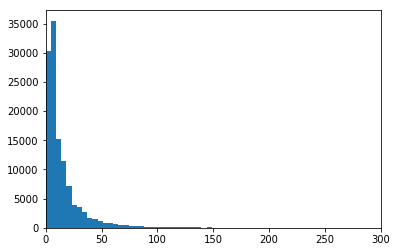

In [388]:
x_train_lan=X_train_filter.apply(len)
x_train_lan=x_train_lan.sort_values()
plt.xlim(0,300)
plt.hist(x_train_lan,bins=1000)
plt.show()

## train word2vec weight

In [14]:
w2v_model=Word2Vec(X_train_filter,size=400,workers=12)

In [439]:
new_sentences=['今天','我',"想要","試試看","訓練","新","的","詞庫"]
w2v_model.build_vocab(new_sentences, update=True)
w2v_model.train(new_sentences,total_examples=w2v_model.corpus_count,epochs=200)

(1526, 2800)

In [15]:
embedding_matrix = np.zeros((len(w2v_model.wv.vocab.items()) + 1, w2v_model.vector_size))
word2idx = {}
vocab_list = [(word, w2v_model.wv[word]) for word, _ in w2v_model.wv.vocab.items()]
for i, vocab in progressbar(enumerate(vocab_list)):
    word, vec = vocab
    embedding_matrix[i + 1] = vec
    word2idx[word] = i + 1

| | #                                             | 26823 Elapsed Time: 0:00:00


## test_to_index、padding 
### prepare X_train、y_train

In [28]:
X_train_filter=np.load("X_train_filter.npy")

['田中', '太郎', '笑', '😂', '知道', '有沒有', '😍', '😍', '小時候', '超愛', '😏']


In [29]:
X_train_index=get_X_index(X_train_filter)
X_train_padding=get_X_padding(X_train_index)
X_train=X_train_padding
print("X_Shape:", X_train.shape)

X_Shape: (120000, 150)


In [30]:
y_train=np.array(y_train_raw).reshape(-1,1)
print("y_Shape:", y_train.shape)

y_Shape: (120000, 1)


### prepare X_test

In [31]:
X_test_split=get_X_split(X_test_raw)
X_test_resub=get_X_resub(X_test_split)
X_test_tokenize=get_X_tokenize(X_test_resub)
X_test_filter=get_X_filter(X_test_tokenize)

np.save("X_test_filter.npy",X_test_filter)
X_test_filter=np.load("X_test_filter.npy")

X_test_index=get_X_index(X_test_filter)
X_test_padding=get_X_padding(X_test_index)
X_test=X_test_padding
print("X_test_Shape:", X_test.shape)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [00:00<00:00, 215583.52it/s]


X_test_Shape: (120000, 150)


## use embedding_matrix above build embedding layer and model

In [32]:
embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
                            output_dim=embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            trainable=False)

In [36]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(128))
# model.add(LSTM(128))
# model.add(GRU(16)) 
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


early_stopping=EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

adam=Adam(lr=0.0001)

model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'],
              )
print(model.summary())



history = model.fit(x=X_train, y=y_train, batch_size=3000, epochs=3, validation_split=0.1,callbacks=[early_stopping])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 400)         10730000  
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               270848    
_________________________________________________________________
dense_7 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 11,198,481
Trainable params: 468,481
Non-trainable params: 10,730,000
_________________________________________________________________
None
Train on 108000 samples, validate on 12000 samples
Epoch 1/3
108000/108000 [==============================] - ETA: 41s 

108000/108000 [==============================] - ETA: 13s - loss: 0.5675 - acc: 0.7127 - binary_accuracy: 0.71 - ETA: 12s - loss: 0.5652 - acc: 0.7130 - binary_accuracy: 0.71 - ETA: 12s - loss: 0.5681 - acc: 0.7098 - binary_accuracy: 0.70 - ETA: 11s - loss: 0.5672 - acc: 0.7098 - binary_accuracy: 0.70 - ETA: 11s - loss: 0.5664 - acc: 0.7111 - binary_accuracy: 0.71 - ETA: 11s - loss: 0.5680 - acc: 0.7117 - binary_accuracy: 0.71 - ETA: 10s - loss: 0.5668 - acc: 0.7122 - binary_accuracy: 0.71 - ETA: 10s - loss: 0.5656 - acc: 0.7117 - binary_accuracy: 0.71 - ETA: 10s - loss: 0.5657 - acc: 0.7123 - binary_accuracy: 0.71 - ETA: 9s - loss: 0.5667 - acc: 0.7108 - binary_accuracy: 0.7108 - ETA: 9s - loss: 0.5659 - acc: 0.7112 - binary_accuracy: 0.711 - ETA: 8s - loss: 0.5656 - acc: 0.7118 - binary_accuracy: 0.711 - ETA: 8s - loss: 0.5655 - acc: 0.7122 - binary_accuracy: 0.712 - ETA: 8s - loss: 0.5655 - acc: 0.7131 - binary_accuracy: 0.713 - ETA: 7s - loss: 0.5650 - acc: 0.7136 - binary_accuracy

In [ ]:
answer_np=model.predict_classes(X_test)

In [463]:
np.save(ROOT+"answer/answer.npy",answer_np)

In [470]:
answer_to_csv()

the answer is ready at answer3.csv


In [ ]:
ans=np.load(ROOT+"answer/answer.npy")
sample=pd.read_csv(ROOT+"data_set/sample_submission.csv")
sample.label=ans
NUM=get_answer_num()
sample.to_csv(ROOT+"answer/answer_"+str(NUM)+".csv",index=False)
print("the answer is ready at answer"+str(NUM)+".csv")